## Tensorboard

In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
! del /q %TMP%\.tensorboard-info\*

The system cannot find the file specified.


In [2]:
%tensorboard --logdir logs/scalars --host localhost

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%matplotlib notebook
import sklearn
import skimage
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy import ndimage, misc

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
from skimage.transform import resize
import pylab
import pydicom as pyd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

import cv2

Using TensorFlow backend.


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
# tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
from skimage import exposure
def dcmchange(orig,clahe,mask) :
    r,c = orig.shape
    new = np.empty((r,c,3), dtype=orig.dtype)
#     new[:,:,:] = orig[:,:,np.newaxis]
    new[:,:,0] = orig[:,:]
    new[:,:,1] = clahe[:,:]
    new[:,:,2] = mask[:,:]
    return new

In [3]:
from skimage import measure, morphology, segmentation

def marker(img):
    h,w = img.shape[:2]
    for row in range(h):
        if img[row, 0] == 1:
            cv2.floodFill(img, None, (0, row), 0)
        if img[row, w-1] == 1:
            cv2.floodFill(img, None, (w-1, row), 0)
    for col in range(w):
        if img[0, col] == 1:
            cv2.floodFill(img, None, (col, 0), 0)
        if img[h-1, col] == 1:
            cv2.floodFill(img, None, (col, h-1), 0)
    holes = img.copy()
    cv2.floodFill(holes, None, (0,0), 1)
    holes = cv2.bitwise_not(holes)
    mask = cv2.bitwise_or(img, holes)
    mask_img = cv2.bitwise_and(img, img, mask=mask)
    return mask_img

## Read Data

In [4]:
p = Path("dataset/")
dirs = p.glob("*")
labels_dict = {'CA lung':0, 'Extra':0, 'Heart and TGV':0, 'Abnormal': 0,
               'Intra': 0, 'No Finding': 1, 'TB': 0, 'Pneumonia' : 0}
count = 0

disease_images = []
normal_images = []
disease_labels = []
normal_labels = []

count_normal = 0
count_disease = 0

for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1][:-1]
#     print(label)
#     print(folder_dir)
    if label == 'Pneumonia' or label == 'No Finding' :
        for img_path in folder_dir.glob("*.dcm"):
#             print(img_path)
#             pic = pyd.read_file(os.path.normpath(img_path))
            target = "./" + str(img_path)
#             print(target)
            pic = pyd.read_file(target)
    #         pic_dir.append(pic)
            pic_r = np.array(pic.pixel_array)
    #         print(pic_r.shape)
            %matplotlib inline 
    #         preprocessing
            clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
            pic_r1 = clahe.apply(pic_r)
            
#             mark = marker(pic_r)
#             plt.imshow(mark)
#             print(mark.shape)
    #         preprocessing
            IMG_PX_SIZE = 224
            resized_org = resize(pic_r, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_clahe = resize(pic_r1, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_equal = exposure.equalize_adapthist(resized_org, clip_limit=0.03)
            #change pic to (224,224,3)
            resized_img = dcmchange(resized_org,resized_clahe,resized_equal)
            resized_img2 = exposure.equalize_adapthist(resized_img, clip_limit=0.03)


            if label == 'Pneumonia' :
                disease_images.append(resized_img2)
                disease_labels.append(labels_dict[label])
#                 heart_images.append(ndimage.rotate(resized_img2, 1, reshape=False))
                count_disease+=1
            elif label == 'No Finding' :
                normal_images.append(resized_img2)
                normal_labels.append(labels_dict[label])
                count_normal+=1

            if count_normal == 200 or count_disease == 200 : 
                break

        count_normal = 0
        count_disease = 0


C:\Users\GhostLinER\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


## Test/Train

In [5]:
disease_images = np.array(disease_images, dtype=np.float32) #heart_images
disease_labels = np.array(disease_labels)
normal_images = np.array(normal_images, dtype=np.float32) #normal_images
normal_labels = np.array(normal_labels)

In [6]:
print("number of sample Heart: {}".format(len(disease_images)))
print("number of sample No Finding: {}".format(len(normal_images)))

number of sample Heart: 200
number of sample No Finding: 200


In [74]:
disease_images[1][223,0]

array([0.03137255, 0.16078432, 0.03137255], dtype=float32)

In [6]:
disease_images[1].shape

(224, 224, 3)

In [7]:
np.max(disease_images[400])

IndexError: index 400 is out of bounds for axis 0 with size 100

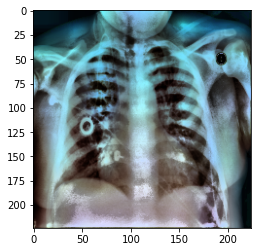

In [7]:
plt.imshow(disease_images[1])

In [29]:
img = disease_images[10]

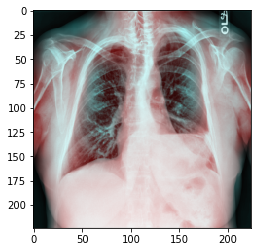

In [32]:
plt.imshow(img)

In [30]:
flip = cv2.flip(img, 1)

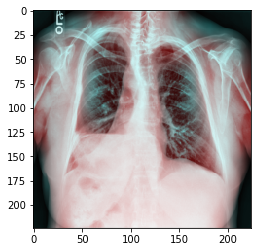

In [31]:
plt.imshow(flip)

## Feature

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

# from tensorflow.keras.applications import VGG16

## Model

In [9]:
def cnn_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 1e-4
    EPOCHS = 30
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    vgg_model = VGG16(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in vgg_model.layers:
        layer.trainable = False
        
    new_model = vgg_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(256, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=vgg_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=16,
        verbose=0, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    print("Path Test")
    y_pred = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
#     #confusion
    confusion(y_test,y_pred_test)
    print("Path Validate")
    confusion(y_val,y_pred)

    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
#     print(fpr)
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
    model.save('model\\pneu\\newvgg16\\'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

In [29]:
from tensorflow.keras.applications import VGG19
def vgg19_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 2e-3
    EPOCHS = 20
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    vgg19_model = VGG19(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in vgg19_model.layers:
        layer.trainable = False
        
    new_model = vgg19_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(64, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=vgg19_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=16,
        verbose=0, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    print("Path Test")
    y_pred = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
#     #confusion
    confusion(y_test,y_pred_test)
    print("Path Validate")
    confusion(y_val,y_pred)

    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
    model.save('model\\pneu\\vgg19\\'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

In [10]:
from tensorflow.keras.applications import InceptionV3
def incepv3_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 1e-3
    EPOCHS = 100
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    incepv3_model = InceptionV3(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in incepv3_model.layers:
        layer.trainable = False
        
    new_model = incepv3_model.output
    new_model = GlobalAveragePooling2D()(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(128, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=incepv3_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer='rmsprop',
#               loss='categorical_crossentropy',
                loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=64,
        verbose=1, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred,axis = 1)
#     print(y_pred)
    #confusion
    confusion(y_test,y_pred)
#     y_score = history.predict(X_test)
#     y_score = model.predict_proba(X_test)[:, 1]    
    return y_pred

In [11]:
from tensorflow.keras.applications import DenseNet121
def dense_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 1e-3
    EPOCHS = 80
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    dense_model = DenseNet121(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in dense_model.layers:
        layer.trainable = False
        
    new_model = dense_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(128, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=dense_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=64,
        verbose=1, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    y_pred = model.predict(X_val)
#     print(y_pred)
    #confusion
    confusion(y_val,y_pred)
#     y_score = history.predict(X_test)
#     y_score = history.predict_proba(X_test)[:, 1]  

    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
#     model.save('model/'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

In [12]:
from tensorflow.keras.applications import ResNet152
def res152_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 5e-3
    EPOCHS = 80
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
#     model_base = keras.Sequential()
# #     model = keras.Sequential([
# #         # Note the input shape is the desired size of the image 150x150 with 3 bytes color
# #         # This is the first convolution
# #         tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3)),
# #         tf.keras.layers.MaxPooling2D(2, 2),
# #         # The second convolution
# #         tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
# #         tf.keras.layers.MaxPooling2D(2,2),
# #         # The third convolution
# #         tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
# #         tf.keras.layers.MaxPooling2D(2,2),
# #         # The fourth convolution
# #         tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
# #         tf.keras.layers.MaxPooling2D(2,2),
# #         # Flatten the results to feed into a DNN
# #         tf.keras.layers.Flatten(),
# #         tf.keras.layers.Dropout(0.5),
# #         # 512 neuron hidden layer
# #         tf.keras.layers.Dense(512, activation='relu'),
# #         # 256 neuron hidden layer
# #         tf.keras.layers.Dense(256, activation='relu'),
# #         tf.keras.layers.Dense(2, activation='softmax')
# #     ])
    
#     dense_model = keras.applications.densenet.DenseNet121(include_top=False, 
#                                                           weights="imagenet", 
#                                                         input_tensor=Input(shape=(224, 224,3)))

    res_model = ResNet152(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in res_model.layers:
        layer.trainable = False
        
    new_model = res_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(64, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=res_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=64,
        verbose=0, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    y_pred = model.predict(X_val)
#     y_roc = model.predict(X_val)
#     y_pred_classes = np.argmax(y_pred,axis = 1)
#     print(y_pred)
    
    #confusion
    confusion(y_val,y_pred)
#     y_score = history.predict(X_test)
#     y_score = history.predict_proba(X_val)[:, 1]
#     print(y_score)

    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
#     model.save('model/'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

## Confusion Matrix

In [10]:
import seaborn as sns
from sklearn.metrics import classification_report 
def confusion(y_test,pred) :
    cm_plot_labels = ['Finding', 'Normal']
    #Confusion Matrix
    %matplotlib inline 

    confusion_mat1 = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
    confusion_mat1 = confusion_mat1.astype('float') / confusion_mat1.sum(axis=1)[:, np.newaxis]
    
#     plot_confusion_matrix(confusion_mat1, cm_plot_labels, title='Confusion Matrix')
    sns.heatmap(confusion_mat1, annot=True, fmt=".2f")
    plt.show()
    
    print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1), target_names=cm_plot_labels))
    

## ROC

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [12]:
def roc(fpr_recv,tpr_recv,acc_recv,num) :

    color = ["orange","green","blue","red","purple"]
    for i in range(num):
        fpr_use = fpr_recv[i]
        tpr_use = tpr_recv[i]
        acc_use = acc_recv[i]
#         print(len(fpr_use))
#         auc = roc_auc_score(y_val_rec, roc_pred)
#         print('AUC Fold %d: %0.4f' %(i,auc))
        
        plt.plot(fpr_use, tpr_use, color='{}'.format(color[i]), label='AUC Fold %d: %0.4f' %(i,acc_use))
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    std_auc = np.std(acc_recv)
    tprs = []
#     auc = []
    mean_fpr = np.linspace(0, 1, 100)
    for i in range(num):
        tprs.append(np.interp(mean_fpr, fpr_recv[i], tpr_recv[i]))
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    print(type(mean_fpr))
    print(type(mean_tpr))
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, color='black', 
             label='AUC Fold Average: %0.4f $\pm$ %0.2f' %(mean_auc, std_auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## Run

In [13]:
def AllinOne(other, normal,text) :
    stck_prob = []
    dis = 0
    #Set Test
    X_test = []
    y_test = []
    other_img = []
    normal_img = []
    for i in range(len(normal)) :
        if i >= 8 * len(normal) / 10 :
            X_test.append(normal[i])
            y_test.append(1)
        else :
            normal_img.append(normal[i])
    for i in range(len(other)) :
        if i >= 8 * len(other) / 10 :
            X_test.append(other[i])
            y_test.append(0)
        else :
            other_img.append(other[i])
    #Set Data
    for k in range(5):
        X_train = []
        y_train = []
        X_val = []
        y_val = []
#         print(dis)
#         print(((8-dis) * len(normal)),((10-dis) * len(normal)))
        for i in range(len(normal_img)) :
            if i >= (8-dis) * len(normal_img) / 10 and i < (10-dis) * len(normal_img) / 10  :
                X_val.append(normal_img[i])
                y_val.append(1)
            else :
                X_train.append(normal_img[i])
                y_train.append(1)
        for i in range(len(other_img)) :
            if i >= (8-dis) * len(other_img) / 10 and i < (10-dis) * len(other_img) / 10  :
                X_val.append(other_img[i])
                y_val.append(0)
            else :
                X_train.append(other_img[i])
                y_train.append(0)
        #add dis
        dis = dis + 2
        #data
        y_train_s = np.array(y_train)
        X_train_s = np.array(X_train, dtype=np.float32) #train_images
        y_test_s = np.array(y_test)
        X_test_s = np.array(X_test, dtype=np.float32) #test_images
        y_val_s = np.array(y_val)
        X_val_s = np.array(X_val, dtype=np.float32) #val_images
        
        print("number of sample Train: {}".format(len(X_train_s)))
        print("number of sample Test: {}".format(len(X_test_s)))
        print("number of sample Val: {}".format(len(X_val_s)))
        
        #change dicom to (224,224,3)
        
        
        #class
        n_classes = 2
        y_train_n = keras.utils.to_categorical(y_train_s, n_classes)
        y_test_n = keras.utils.to_categorical(y_test_s, n_classes)
        y_val_n = keras.utils.to_categorical(y_val_s, n_classes)
        # Feature
#         X_train_n,X_test_n = scaling(X_train_s,X_test_s)
        # run model
        probs = dense_model(X_train_s,y_train_n,X_test_s,y_test_n,X_val_s,y_val_n,k,text)    
#         print(y_test_n.shape)
#         print(probs.shape)
#         fpr, tpr, thresholds = roc_curve(y_test_n[:,0], probs[:,0])
#         roc_auc = metrics.auc(fpr, tpr)
#         print(roc_auc)
        # confusion
        stck_prob.append(probs)
    # ROC
    roc(y_test_n,stck_prob)

## Increase

In [14]:
def incre(data,labels):
    new_data = []
    new_label = []
    for i in range(data.shape[0]):
        flip = cv2.flip(data[i], 1)
        new_data.append(ndimage.rotate(flip, -5, reshape=False))
        new_data.append(data[i])
        new_data.append(ndimage.rotate(data[i], 5, reshape=False))
        new_data.append(flip)
        new_data.append(ndimage.rotate(data[i], -5, reshape=False))
        new_data.append(ndimage.rotate(flip, 5, reshape=False))
        new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
    new_data = np.array(new_data)
    new_label = np.array(new_label)
    return new_data,new_label

## Abnormal

In [15]:
from sklearn.model_selection import KFold
def idk(other, normal,text) :
    k = 0
    # set to 5 folds
    box_tpr = []
    box_fpr = []
    box_acc = []
    #Set Test
    data = []
    label = []
    index = 0
    for i in range(5):
        for count in range(int(normal.shape[0]/5)):
            data.append(normal[index+count])
            label.append(1)
#             print(index+count)
        for count in range(int(other.shape[0]/5)):
            data.append(other[index+count])
            label.append(0)
        index+=int(normal.shape[0]/5)
    data = np.array(data)
    label = np.array(label)
    train_data, X_test, label_train, y_test = train_test_split(data, label, test_size=0.2)
    X_test_n, y_test_n = incre(X_test,y_test)
    n_classes = 2
    y_test_n = keras.utils.to_categorical(y_test_n, n_classes)
    kf = KFold(n_splits=5)
    for train, val in kf.split(train_data):
        X_train = train_data[train]
        X_val = train_data[val]
        y_train = label_train[train]
        y_val = label_train[val]
        
        X_train_n, y_train_n = incre(X_train,y_train)
        X_val_n, y_val_n = incre(X_val,y_val)
        #class
        y_train_n = keras.utils.to_categorical(y_train_n, n_classes)
        y_val_n = keras.utils.to_categorical(y_val_n, n_classes)
#         print(y_test)
        
        print("number of sample Train: {}".format(len(X_train_n)))
        print("number of sample Test: {}".format(len(X_test_n)))
        print("number of sample Val: {}".format(len(X_val_n)))
        
        
        recv_fpr,recv_tpr,recv_acc = cnn_model(X_train_n,y_train_n,X_test_n,y_test_n,X_val_n,y_val_n,k,text)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        k += 1
        
        #only one round
#         if k == 1: break
        
    # ROC
    roc(box_fpr,box_tpr,box_acc,k)

number of sample Train: 1536
number of sample Test: 480
number of sample Val: 384
Average test accuracy:  0.7375
Average test loss:  0.5309094907767656


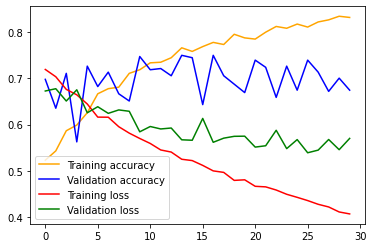

Path Test


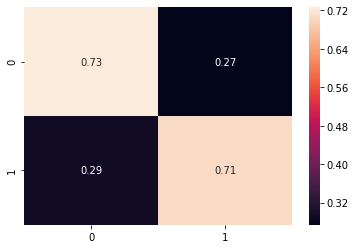

              precision    recall  f1-score   support

     Finding       0.73      0.73      0.73       252
      Normal       0.70      0.71      0.70       228

    accuracy                           0.72       480
   macro avg       0.72      0.72      0.72       480
weighted avg       0.72      0.72      0.72       480

Path Validate


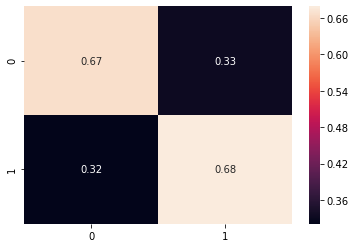

              precision    recall  f1-score   support

     Finding       0.55      0.67      0.61       144
      Normal       0.77      0.68      0.72       240

    accuracy                           0.67       384
   macro avg       0.66      0.67      0.66       384
weighted avg       0.69      0.67      0.68       384

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model\pneu\newvgg16\Pneumonia_0\assets
number of sample Train: 1536
number of sample Test: 480
number of sample Val: 384
Average test accuracy:  0.7355469
Average test loss:  0.5299521132165359


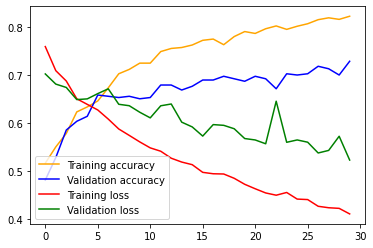

Path Test


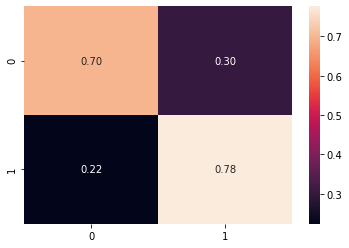

              precision    recall  f1-score   support

     Finding       0.78      0.70      0.73       252
      Normal       0.70      0.78      0.74       228

    accuracy                           0.74       480
   macro avg       0.74      0.74      0.74       480
weighted avg       0.74      0.74      0.74       480

Path Validate


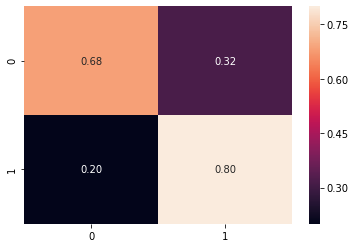

              precision    recall  f1-score   support

     Finding       0.84      0.68      0.75       234
      Normal       0.62      0.80      0.70       150

    accuracy                           0.73       384
   macro avg       0.73      0.74      0.73       384
weighted avg       0.75      0.73      0.73       384

INFO:tensorflow:Assets written to: model\pneu\newvgg16\Pneumonia_1\assets
number of sample Train: 1536
number of sample Test: 480
number of sample Val: 384
Average test accuracy:  0.7285373
Average test loss:  0.5418466485519376


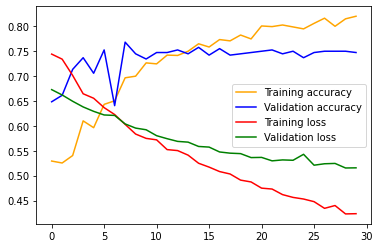

Path Test


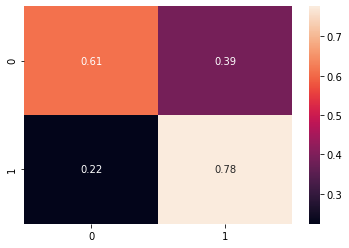

              precision    recall  f1-score   support

     Finding       0.75      0.61      0.67       252
      Normal       0.64      0.78      0.70       228

    accuracy                           0.69       480
   macro avg       0.70      0.69      0.69       480
weighted avg       0.70      0.69      0.69       480

Path Validate


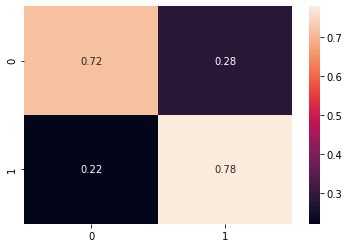

              precision    recall  f1-score   support

     Finding       0.75      0.72      0.73       186
      Normal       0.74      0.78      0.76       198

    accuracy                           0.75       384
   macro avg       0.75      0.75      0.75       384
weighted avg       0.75      0.75      0.75       384

INFO:tensorflow:Assets written to: model\pneu\newvgg16\Pneumonia_2\assets
number of sample Train: 1536
number of sample Test: 480
number of sample Val: 384
Average test accuracy:  0.7438803
Average test loss:  0.5308756515642421


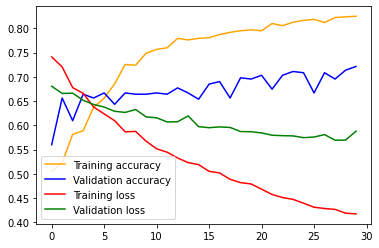

Path Test


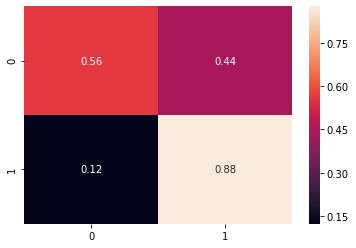

              precision    recall  f1-score   support

     Finding       0.84      0.56      0.67       252
      Normal       0.65      0.88      0.74       228

    accuracy                           0.71       480
   macro avg       0.74      0.72      0.71       480
weighted avg       0.74      0.71      0.71       480

Path Validate


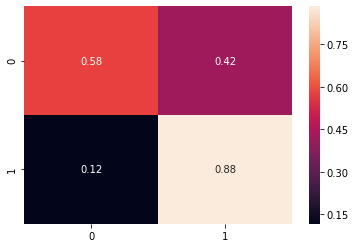

              precision    recall  f1-score   support

     Finding       0.85      0.58      0.69       204
      Normal       0.65      0.88      0.75       180

    accuracy                           0.72       384
   macro avg       0.75      0.73      0.72       384
weighted avg       0.76      0.72      0.72       384

INFO:tensorflow:Assets written to: model\pneu\newvgg16\Pneumonia_3\assets
number of sample Train: 1536
number of sample Test: 480
number of sample Val: 384
Average test accuracy:  0.72523874
Average test loss:  0.5458998852512903


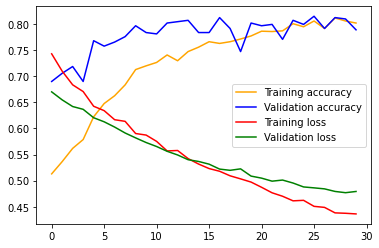

Path Test


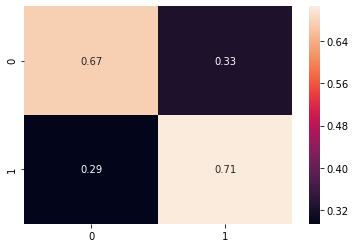

              precision    recall  f1-score   support

     Finding       0.72      0.67      0.70       252
      Normal       0.66      0.71      0.68       228

    accuracy                           0.69       480
   macro avg       0.69      0.69      0.69       480
weighted avg       0.69      0.69      0.69       480

Path Validate


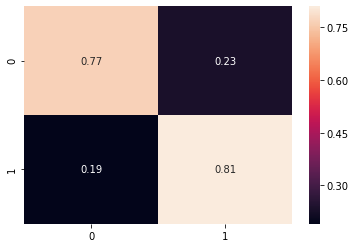

              precision    recall  f1-score   support

     Finding       0.78      0.77      0.77       180
      Normal       0.80      0.81      0.80       204

    accuracy                           0.79       384
   macro avg       0.79      0.79      0.79       384
weighted avg       0.79      0.79      0.79       384

INFO:tensorflow:Assets written to: model\pneu\newvgg16\Pneumonia_4\assets
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


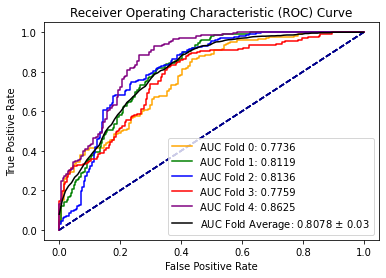

In [16]:
idk(disease_images, normal_images,"Pneumonia")

In [35]:
idk(disease_images, normal_images,"Pneumonia")

number of sample Train: 1024
number of sample Test: 320
number of sample Val: 256
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________

TypeError: cannot unpack non-iterable NoneType object

In [30]:
from sklearn.model_selection import KFold
def vgg_19(other, normal,text) :
    k = 0
    # set to 5 folds
    box_tpr = []
    box_fpr = []
    box_acc = []
    #Set Test
    data = []
    label = []
    index = 0
    for i in range(5):
        for count in range(int(normal.shape[0]/5)):
            data.append(normal[index+count])
            label.append(1)
#             print(index+count)
        for count in range(int(other.shape[0]/5)):
            data.append(other[index+count])
            label.append(0)
        index+=int(normal.shape[0]/5)
    data = np.array(data)
    label = np.array(label)
    train_data, X_test, label_train, y_test = train_test_split(data, label, test_size=0.2)
    X_test_n, y_test_n = incre(X_test,y_test)
    n_classes = 2
    y_test_n = keras.utils.to_categorical(y_test_n, n_classes)
    kf = KFold(n_splits=5)
    for train, val in kf.split(train_data):
        X_train = train_data[train]
        X_val = train_data[val]
        y_train = label_train[train]
        y_val = label_train[val]
        
        X_train_n, y_train_n = incre(X_train,y_train)
        X_val_n, y_val_n = incre(X_val,y_val)
        #class
        y_train_n = keras.utils.to_categorical(y_train_n, n_classes)
        y_val_n = keras.utils.to_categorical(y_val_n, n_classes)
#         print(y_test)
        
        print("number of sample Train: {}".format(len(X_train_n)))
        print("number of sample Test: {}".format(len(X_test_n)))
        print("number of sample Val: {}".format(len(X_val_n)))
        
        
        recv_fpr,recv_tpr,recv_acc = vgg19_model(X_train_n,y_train_n,X_test_n,y_test_n,X_val_n,y_val_n,k,text)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        k += 1
        
        #only one round
#         if k == 1: break
        
    # ROC
    roc(box_fpr,box_tpr,box_acc,k)

number of sample Train: 1024
number of sample Test: 320
number of sample Val: 256
Average test accuracy:  0.73945314
Average test loss:  0.5115258381236345


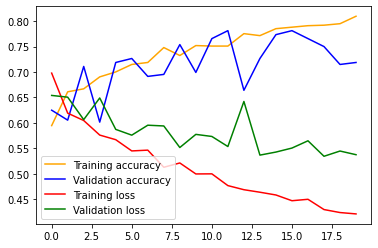

Path Test


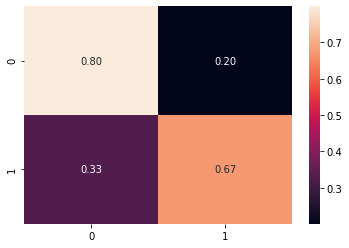

              precision    recall  f1-score   support

     Finding       0.72      0.80      0.76       164
      Normal       0.76      0.67      0.71       156

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320

Path Validate


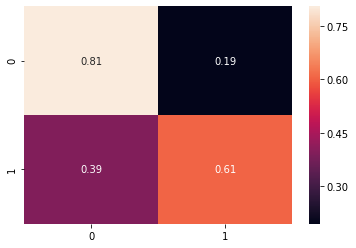

              precision    recall  f1-score   support

     Finding       0.72      0.81      0.76       144
      Normal       0.71      0.61      0.65       112

    accuracy                           0.72       256
   macro avg       0.72      0.71      0.71       256
weighted avg       0.72      0.72      0.72       256

INFO:tensorflow:Assets written to: model\pneu\vgg19\Pneumonia_0\assets
number of sample Train: 1024
number of sample Test: 320
number of sample Val: 256
Average test accuracy:  0.7581543
Average test loss:  0.4965959292952903


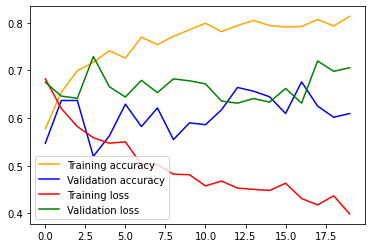

Path Test


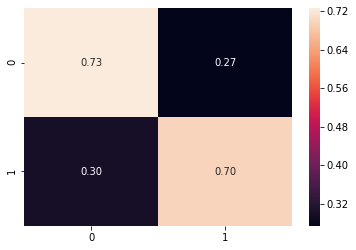

              precision    recall  f1-score   support

     Finding       0.72      0.73      0.72       164
      Normal       0.71      0.70      0.70       156

    accuracy                           0.71       320
   macro avg       0.71      0.71      0.71       320
weighted avg       0.71      0.71      0.71       320

Path Validate


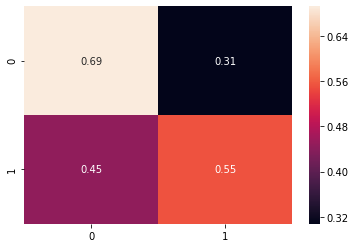

              precision    recall  f1-score   support

     Finding       0.51      0.69      0.59       104
      Normal       0.72      0.55      0.63       152

    accuracy                           0.61       256
   macro avg       0.62      0.62      0.61       256
weighted avg       0.64      0.61      0.61       256

INFO:tensorflow:Assets written to: model\pneu\vgg19\Pneumonia_1\assets
number of sample Train: 1024
number of sample Test: 320
number of sample Val: 256
Average test accuracy:  0.7415039
Average test loss:  0.5139796406612731


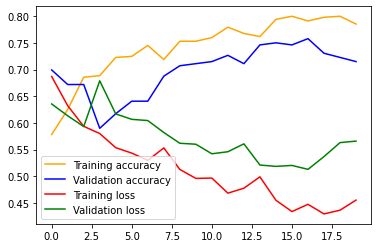

Path Test


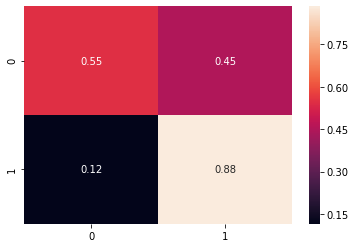

              precision    recall  f1-score   support

     Finding       0.83      0.55      0.66       164
      Normal       0.65      0.88      0.75       156

    accuracy                           0.71       320
   macro avg       0.74      0.72      0.71       320
weighted avg       0.74      0.71      0.70       320

Path Validate


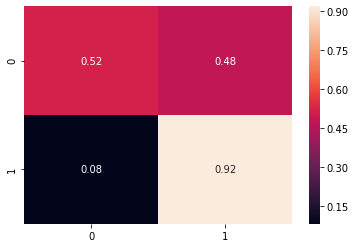

              precision    recall  f1-score   support

     Finding       0.87      0.52      0.65       132
      Normal       0.64      0.92      0.76       124

    accuracy                           0.71       256
   macro avg       0.76      0.72      0.71       256
weighted avg       0.76      0.71      0.70       256

INFO:tensorflow:Assets written to: model\pneu\vgg19\Pneumonia_2\assets
number of sample Train: 1024
number of sample Test: 320
number of sample Val: 256
Average test accuracy:  0.72744143
Average test loss:  0.5321981697925366


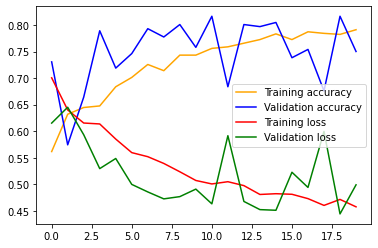

Path Test


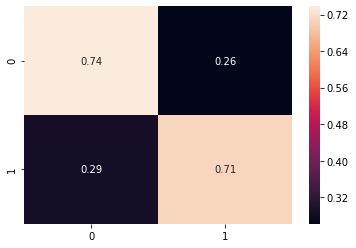

              precision    recall  f1-score   support

     Finding       0.73      0.74      0.73       164
      Normal       0.72      0.71      0.72       156

    accuracy                           0.73       320
   macro avg       0.72      0.72      0.72       320
weighted avg       0.72      0.72      0.72       320

Path Validate


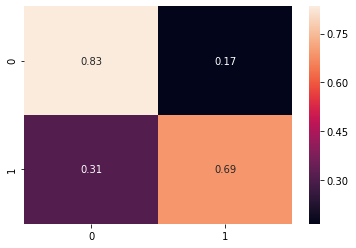

              precision    recall  f1-score   support

     Finding       0.66      0.83      0.74       108
      Normal       0.85      0.69      0.76       148

    accuracy                           0.75       256
   macro avg       0.76      0.76      0.75       256
weighted avg       0.77      0.75      0.75       256

INFO:tensorflow:Assets written to: model\pneu\vgg19\Pneumonia_3\assets
number of sample Train: 1024
number of sample Test: 320
number of sample Val: 256
Average test accuracy:  0.74135745
Average test loss:  0.5210633673821576


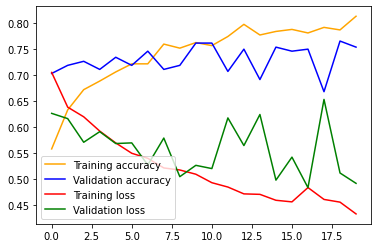

Path Test


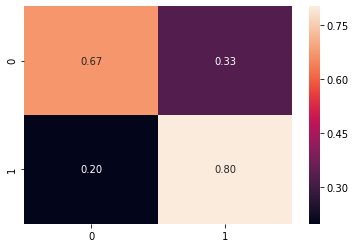

              precision    recall  f1-score   support

     Finding       0.78      0.67      0.72       164
      Normal       0.70      0.80      0.75       156

    accuracy                           0.73       320
   macro avg       0.74      0.74      0.73       320
weighted avg       0.74      0.73      0.73       320

Path Validate


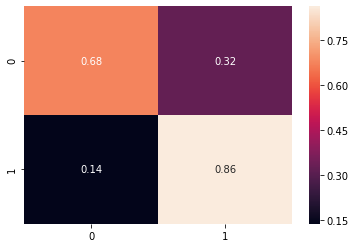

              precision    recall  f1-score   support

     Finding       0.87      0.68      0.76       148
      Normal       0.66      0.86      0.75       108

    accuracy                           0.75       256
   macro avg       0.76      0.77      0.75       256
weighted avg       0.78      0.75      0.75       256

INFO:tensorflow:Assets written to: model\pneu\vgg19\Pneumonia_4\assets
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


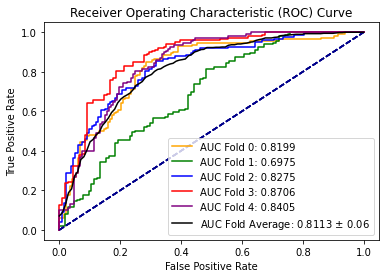

In [31]:
vgg_19(disease_images, normal_images,"Pneumonia")